In [1]:
!pip install torchsummary
!pip install ipdb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 19.7 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn as nn
from torch.utils.data import random_split, DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision import models
from torchvision.datasets import CIFAR10
from torchsummary import summary
import numpy as np
import os
import tensorboard
import ipdb
import torch.optim as optim

def shuffle_minibatch(x, y):
    assert x.size(0)== y.size(0)
    indices = torch.randperm(x.size(0))
    return x[indices], y[indices]

def get_accuracy(preds, actual):
    assert len(preds) == len(actual)

    total = len(actual)
    _, predicted = torch.max(preds.data, axis=1)
    correct = (predicted == actual).sum().item()
    return correct / total

# Load Data

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = CIFAR10(root='./cifar10_data', train=True, download=True, transform=transform)
train_size = int(0.9 * len(trainset))
val_size = len(trainset) - train_size
train_subset, val_subset = random_split(trainset, [train_size, val_size])
trainloader = DataLoader(train_subset, batch_size=256, shuffle=True, num_workers=2)
valloader = DataLoader(val_subset, batch_size=256, shuffle=False, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./cifar10_data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=1, shuffle=False, num_workers=2)

cifar10_labels = {
    0: 'airplane',
    1: 'automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck'
}

100%|██████████| 170498071/170498071 [00:04<00:00, 34784537.96it/s]


Extracting ./cifar10_data/cifar-10-python.tar.gz to ./cifar10_data
Files already downloaded and verified


In [63]:
data, label = trainset.__getitem__(1)
print('shape of the image data:    ' + str(data.shape))

shape of the image data:    torch.Size([3, 32, 32])


# Display some image

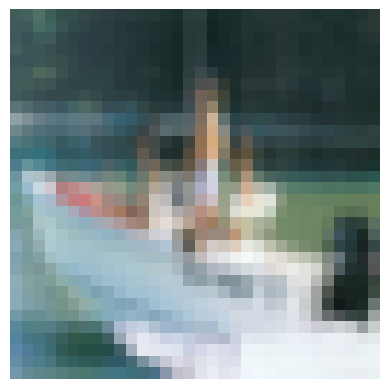

['ship']


In [64]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def show_img(img):
    img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)
# show images
show_img(torchvision.utils.make_grid(images[0]))
# print labels
# mapped_labels = [cifar10_labels[label.item()] for label in labels]
mapped_labels = [cifar10_labels[labels[0].item()]]
print(mapped_labels)

# Define a Convolutional Neural Network

In [65]:
class My_CNN(nn.Module):
    def __init__(self):
        super(My_CNN, self).__init__()

        # Manually define the feature layers
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),  # layer 0
            nn.ReLU(inplace=True),  # layer 1
            nn.MaxPool2d(kernel_size=2, stride=2),  # layer 2
            nn.Conv2d(64, 128, kernel_size=3, padding=1),  # layer 3
            nn.ReLU(inplace=True),  # layer 4
            nn.MaxPool2d(kernel_size=2, stride=2),  # layer 5
            nn.Conv2d(128, 256, kernel_size=3, padding=1),  # layer 6
            nn.ReLU(inplace=True)  # layer 7
        )

        self.fc = nn.Linear(256, 10)
        self.pool = nn.AdaptiveAvgPool2d((1, 1))

        for param in self.features.parameters():
            param.requires_grad = True

        # Load pretrained weights
        self.load_pretrained_weights()

    def load_pretrained_weights(self):
        # Load the pretrained VGG11 model
        vgg11 = torchvision.models.vgg11(pretrained=True)
        vgg_state_dict = vgg11.state_dict()

        # CAN YOU MANUALLY LOAD THE PRE-TRAINED VGG11 WEIGHT INTO OUR MODEL FOR FINE-TUNING?
        # THE FEATURE EXTRACTORS OF VGG11 HAVE THIS FORMAT
        # FOR EXAMPLE, THE WEIGHT AND BIAS OF THE #8 LAYER OF VGG11 WILL BE AT
        # vgg_state_dict['features.8.weight'] and vgg_state_dict['features.8.bias']
        # ON THE OTHER END, THE Nth WEIGHT AND BIAS OF OUR MODEL WILL BE AT
        # self.features[N].weight.data & self.features[B].bias.data

        #(0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        #(1): ReLU(inplace=True)
        #(2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        #(3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        #(4): ReLU(inplace=True)
        #(5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        #(6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        #(7): ReLU(inplace=True)
        #(8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        #(9): ReLU(inplace=True)
        #(10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        #(11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        #(12): ReLU(inplace=True)
        #(13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        #(14): ReLU(inplace=True)
        #(15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        #(16): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        #(17): ReLU(inplace=True)
        #(18): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        #(19): ReLU(inplace=True)
        #(20): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)

        # Manually load each conv layer's weights and bias
        ######## YOUR CODE HERE. ########
        self.features[0].weight.data = ????
        ######## YOUR CODE HERE. ########

    def forward(self, x):
        x = self.features(x)
        x = self.pool(x)[:, :, 0, 0]
        x = self.fc(x)
        return x

In [69]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = My_CNN().to(device)
# Print summary of our model
summary(net, input_size=(3, 32, 32))
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.05, momentum=0.9)
print(optimizer)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
              ReLU-2           [-1, 64, 32, 32]               0
         MaxPool2d-3           [-1, 64, 16, 16]               0
            Conv2d-4          [-1, 128, 16, 16]          73,856
              ReLU-5          [-1, 128, 16, 16]               0
         MaxPool2d-6            [-1, 128, 8, 8]               0
            Conv2d-7            [-1, 256, 8, 8]         295,168
              ReLU-8            [-1, 256, 8, 8]               0
 AdaptiveAvgPool2d-9            [-1, 256, 1, 1]               0
           Linear-10                   [-1, 10]           2,570
Total params: 373,386
Trainable params: 373,386
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 1.94
Params size (MB): 1.42
Estimated T

# Defining a Loss Function and optimizer

# Training our model

In [70]:
EPOCHS = 30
CUTMIX_ALPHA = 1.0
W, H = 32, 32
print(EPOCHS)

20


In [72]:
def save_checkpoint(state, filename="checkpoint.pth"):
    print(f"Saving checkpoint to {filename} ...")
    torch.save(state, filename)

checkpoint_dir = './checkpoints'
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

train_loss_list, train_acc_list, val_loss_list, val_acc_list = [], [], [], []
best_val_acc = 0


for epoch in range(EPOCHS):
    net.train()  # Set model to training mode
    total_steps = len(trainloader)
    running_loss = 0.0
    running_acc = 0.0

    for i, (x_train, y_train) in enumerate(trainloader):
        x_train = x_train.to(device)
        y_train = y_train.to(device)

        # Forward pass
        y_preds = net(x_train)

        # Compute loss
        loss = criterion(y_preds, y_train)

        running_loss += loss.item()

        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Compute training accuracy
        train_acc = get_accuracy(y_preds, y_train)
        running_acc += train_acc

    # At the end of each epoch, calculate the average loss and accuracy
    avg_train_loss = running_loss / total_steps
    avg_train_acc = running_acc / total_steps
    train_loss_list.append(avg_train_loss)
    train_acc_list.append(avg_train_acc)

    # Validation phase
    net.eval()  # Set model to evaluation mode
    val_loss = 0.0
    val_acc_total = 0

    # We'll use the same DataLoader structure as training,
    # but when evaluating we don't optimize - which means no gradients needed.
    # Make sure your model knows it's in evaluation mode, and remember to track
    # those metrics without backpropagation. After all batches are done,
    # average those numbers to see how well your model is really doing!
    # Hint: What pieces from the training loop can we skip during evaluation?

    with torch.no_grad():  # Disable gradient computation for validation
    #### YOUR CODE HERE ####
        for X_val, Y_val in ???
            val_preds = ???
            # Compute validation loss
            val_loss += ???
            # Compute validation accuracy
            val_acc = ???
            val_acc_total += ???
    #### YOUR CODE HERE ####

    avg_val_loss = val_loss / len(valloader)  # Average validation loss
    avg_val_acc = val_acc_total / len(valloader)  # Average validation accuracy
    val_loss_list.append(avg_val_loss)
    val_acc_list.append(avg_val_acc)

    if avg_val_acc > best_val_acc:
      best_val_acc = avg_val_acc
      checkpoint = {
          'epoch': epoch + 1,
          'model_state_dict': net.state_dict(),
          'optimizer_state_dict': optimizer.state_dict(),
          'train_loss_list': train_loss_list,
          'train_acc_list': train_acc_list,
          'val_loss_list': val_loss_list,
          'val_acc_list': val_acc_list,
          'best_val_acc': best_val_acc,
      }
      save_checkpoint(checkpoint, filename=os.path.join(checkpoint_dir, f'best_model_epoch_{epoch + 1}.pth'))

    # Print training and validation loss and accuracy at the end of each epoch
    print(f'Epoch [{epoch + 1}/{EPOCHS}], Train Loss: {avg_train_loss:.4f}, Train Accuracy: {avg_train_acc * 100:.2f}%, '
          f'Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {avg_val_acc * 100:.2f}%')


Saving checkpoint to ./checkpoints/best_model_epoch_1.pth ...
Epoch [1/20], Train Loss: 0.5523, Train Accuracy: 81.29%, Validation Loss: 0.6024, Validation Accuracy: 79.14%
Saving checkpoint to ./checkpoints/best_model_epoch_2.pth ...
Epoch [2/20], Train Loss: 0.4993, Train Accuracy: 82.99%, Validation Loss: 0.5409, Validation Accuracy: 81.26%
Epoch [3/20], Train Loss: 0.4679, Train Accuracy: 84.10%, Validation Loss: 0.5525, Validation Accuracy: 81.22%
Saving checkpoint to ./checkpoints/best_model_epoch_4.pth ...
Epoch [4/20], Train Loss: 0.4310, Train Accuracy: 85.34%, Validation Loss: 0.5360, Validation Accuracy: 81.41%
Saving checkpoint to ./checkpoints/best_model_epoch_5.pth ...
Epoch [5/20], Train Loss: 0.4104, Train Accuracy: 85.98%, Validation Loss: 0.5307, Validation Accuracy: 82.06%
Epoch [6/20], Train Loss: 0.3628, Train Accuracy: 87.46%, Validation Loss: 0.5605, Validation Accuracy: 80.51%
Saving checkpoint to ./checkpoints/best_model_epoch_7.pth ...
Epoch [7/20], Train Loss

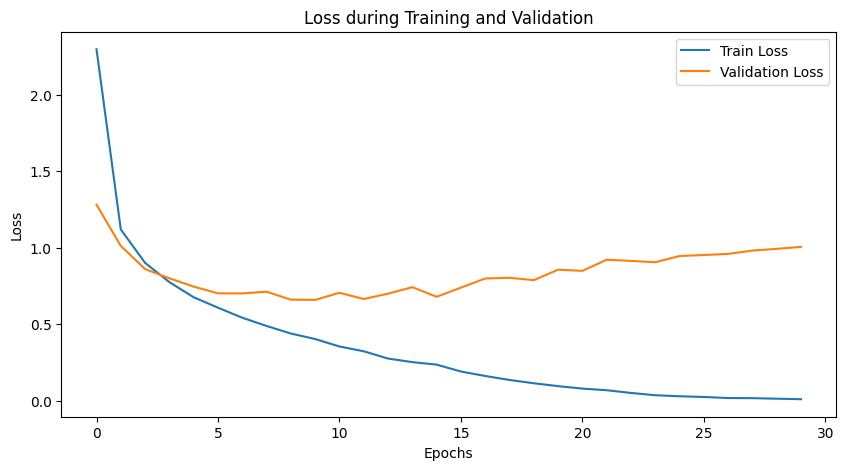

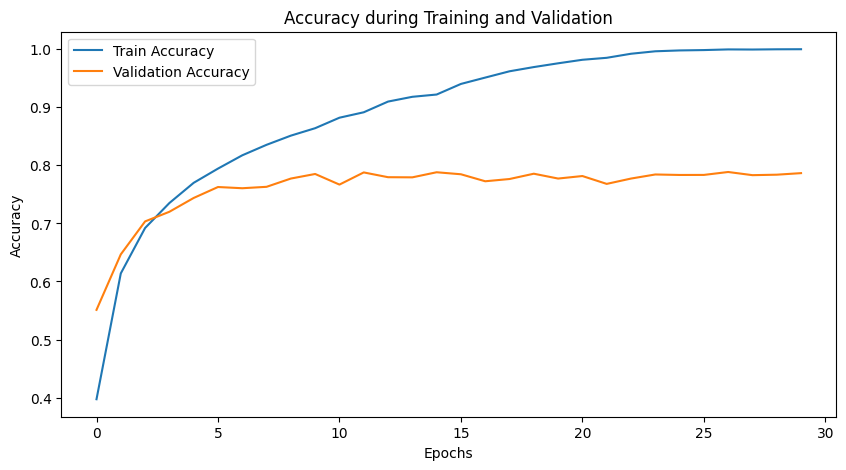

In [19]:
# Plot loss
plt.figure(figsize=(10,5))
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('Loss during Training and Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.figure(figsize=(10,5))
plt.plot(train_acc_list, label='Train Accuracy')
plt.plot(val_acc_list, label='Validation Accuracy')
plt.title('Accuracy during Training and Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Inference testing data

In [ ]:
# checkpoint = torch.load('/content/checkpoints/best_model_epoch_59.pth')
# net.load_state_dict(checkpoint['model_state_dict'])

In [20]:
net.eval()

# To store the overall accuracy
total_correct = 0
total_samples = 0

# Disable gradient computation for inference
with torch.no_grad():
    for images, labels in testloader:  # Iterate through the test set
    #### NOW IS THE SIMPLE PART: WRITE YOUR OWN CODE FOR CALCULATING THE TESTING ACCURACY
    #### YOUR CODE HERE ####
        # Forward pass (inference)
        # Get predictions (class with the highest score)
        # Accumulate total correct predictions
        total_correct += ???
        total_samples += ???
    #### YOUR CODE HERE ####

# Calculate accuracy
accuracy = total_correct / total_samples * 100
print(f'Test Accuracy: {accuracy:.2f}%')


Test Accuracy: 78.77%


# Gradcam

In [22]:
!pip install torchcam

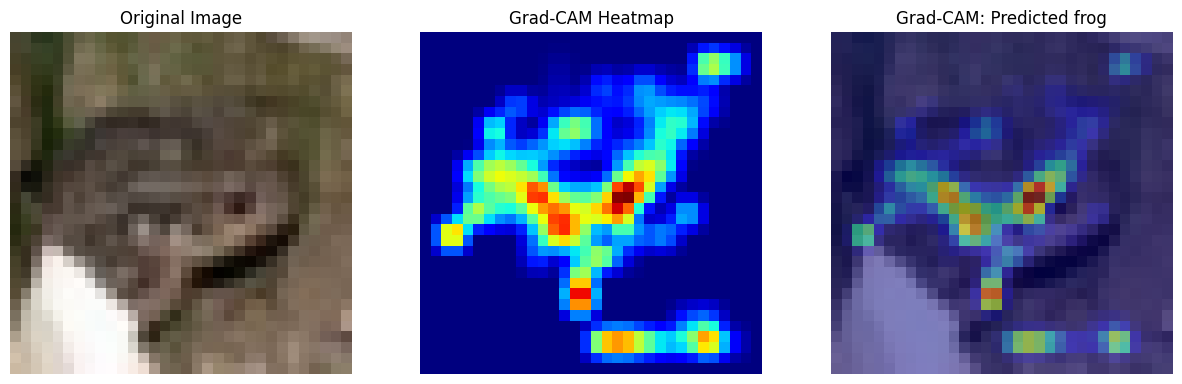

In [75]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchcam.methods import GradCAM
from torchcam.utils import overlay_mask
from torchvision.transforms.functional import to_pil_image
import torch.nn as nn

def unnormalize(tensor, mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)):
    mean = torch.tensor(mean).to(tensor.device).view(-1, 1, 1)
    std = torch.tensor(std).to(tensor.device).view(-1, 1, 1)
    tensor = tensor * std + mean
    return tensor

net.train()
for module in net.modules():
    if isinstance(module, nn.BatchNorm2d):
        module.eval()

for module in net.modules():
    if isinstance(module, nn.Dropout):
        module.p = 0

cam_extractor = GradCAM(net, target_layer=net.features[4])

data_iter = iter(testloader)
images, labels = next(data_iter)

images, labels = testset.__getitem__(np.random.randint(100))

images = images.unsqueeze(0).to(device)
images.requires_grad = True

outputs = net(images)
_, predicted = torch.max(outputs, 1)
class_idx = predicted[0].item()

output = outputs[0].unsqueeze(0)

activation_map = cam_extractor(class_idx, output)

activation_map = activation_map[0]

if activation_map.dim() == 3:
    activation_map = activation_map.mean(dim=0)

activation_map = F.interpolate(activation_map.unsqueeze(0).unsqueeze(0), size=(32, 32), mode='bilinear', align_corners=False)
activation_map = activation_map.squeeze(0).squeeze(0)
activation_map = activation_map - activation_map.min()
activation_map = activation_map / (activation_map.max() - activation_map.min() + 1e-8)

activation_map_pil = to_pil_image(activation_map.cpu(), mode='F')
image_pil = to_pil_image(unnormalize(images[0].cpu()))

result = overlay_mask(image_pil, activation_map_pil, alpha=0.5)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(image_pil)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(activation_map.cpu(), cmap='jet')
plt.title('Grad-CAM Heatmap')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(result)
plt.title(f'Grad-CAM: Predicted {cifar10_labels[class_idx]}')
plt.axis('off')

plt.show()
